In [ ]:
# default_exp g_models.lstm_lm

# all_cuda

# LSTM Language Model

> LSTM-based language model

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export

from mrl.imports import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.g_models.generative_base import *

## LSTM Language Models

LSTM language models are a type of autoregressive generative model. This particular type of model is a good fit for RL-based optimization as they are light, robust and easy to optimize. These models make use of the [LSTM](https://arxiv.org/abs/1402.1128) architecture design.

Language models are trained in a self-supervised fashion by next token prediction. Given a series of tokens, the model predicts a probability distribution over he next token. Self supervised training is very fast and doesn't require any data labels. Each text string in the dataset labels itself.

During generation, we sample from the model in an autoregression fashion. Given an input token, the model predicts aa distribution of tokens over the next token. We then sample from that distributiona and feed the selected token back into the model. We repeat this process until either an end of sentence (EOS) token is predicted, or the generated sequence reaches a maximum allowed length.

During sampling, we save the log probability of each token predicted. This gives us a probability value for the model's estimated likelihood of the generated compound. We can also backprop through this value.

### LSTM_LM

The `LSTM_LM` model is a bare-bones LSTM language model. The model consists of an embedding layer, a series of LSTM layers, and a final output layer that generates a prediction.

In [ ]:
# export

class LSTM_LM(GenerativeModel):
    '''    
    LSTM_LM - LSTM language model

    Inputs:

    - `d_vocab int`: vocab size

    - `d_embedding int`: embedding size

    - `d_hidden int`: hidden dimension

    - `n_layers int`: number of LSTM layers

    - `input_dropout float`: dropout on the embedding layer

    - `lstm_dropout float`: dropout on the LSTM layers

    - `bos_idx int`: beginning of sentence token

    - `bidir bool`: if the LSTMs are bidirectional. 
    Must be False for use in generative models

    - `tie_weights bool`: if True, tie the weights of 
    the embedding and the output layer
    '''
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers,
                input_dropout=0., lstm_dropout=0., bos_idx=0, 
                bidir=False, tie_weights=False):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        
        self.lstm = LSTM(d_embedding, d_hidden, d_embedding, n_layers,
                                     bidir=bidir, input_dropout=input_dropout,
                                     lstm_dropout=lstm_dropout)
        
        self.head = nn.Linear(d_embedding, d_vocab)
        
        if tie_weights:
            self.embedding.weight = self.head.weight
            
        self.bos_idx = bos_idx

    def _forward(self, x, hiddens=None):
        x = self.embedding(x)
        encoded, hiddens = self.lstm(x, hiddens)
        output = self.head(encoded)
        return output, hiddens, encoded
        
    def forward(self, x, hiddens=None):
        output, hiddens, encoded = self._forward(x, hiddens)
        
        return output
    
    def x_to_latent(self, x):
        return None
    
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True):
        '''
        sample - sample from the model
        
        Inputs:
        
        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector 

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling. 
        If False, use argmax greedy sampling
            
        Returns:
        
        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        
        current_device = next(self.parameters()).device
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        lps = []

        hiddens = None
        
        for i in range(sl):
            x, hiddens, encoded = self._forward(idxs, hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
    
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        '''
        sample_no_grad - sample from the model without saving values for 
        gradient calculation
        
        Inputs:
        
        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector 

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling. 
        If False, use argmax greedy sampling
            
        Returns:
        
        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        with torch.no_grad():
            return self.sample(bs, sl, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        '''
        get_rl_tensors - generate values needed for RL training
        
        Inputs:
        
        - `x torch.LongTensor[bs, sl]`: x value
            
        - `y torch.LongTensor[bs, sl]`: y value

        - `temperature float`: sample temperature

        - `latent None`: latent vector. LSTM_LM does not use latent 
        vectors, this keyword is included for compatibility 
            
        Returns:
        
        - `output torch.FloatTensor[bs, sl, d_vocab]`: output of the model

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: log probabilities. 
        Log softmax of `output` values

        - `lps_gathered torch.FloatTensor[bs, sl]`: log probabilities 
        gathered by the values in `y`

        - `encoded torch.FloatTensor[bs, sl, d_embedding]`: output from 
        final LSTM layer
        '''
        output, hiddens, encoded = self._forward(x)
        output.div_(temperature)
        lps = F.log_softmax(output, -1)
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded

In [ ]:
show_doc(LSTM_LM.sample)

<h4 id="LSTM_LM.sample" class="doc_header"><code>LSTM_LM.sample</code><a href="__main__.py#L61" class="source_link" style="float:right">[source]</a></h4>

> <code>LSTM_LM.sample</code>(**`bs`**, **`sl`**, **`z`**=*`None`*, **`temperature`**=*`1.0`*, **`multinomial`**=*`True`*)

sample - sample from the model

Inputs:

- `bs int`: batch size

- `sl int`: maximum sequence length

- `z Optional[torch.Tensor[bs, d_latent]]`: latent vector 

- `temperature float`: sample temperature

- `multinomial bool`: if True, use multinomial sampling. 
If False, use argmax greedy sampling
    
Returns:

- `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

- `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities

In [ ]:
show_doc(LSTM_LM.get_rl_tensors)

<h4 id="LSTM_LM.get_rl_tensors" class="doc_header"><code>LSTM_LM.get_rl_tensors</code><a href="__main__.py#L132" class="source_link" style="float:right">[source]</a></h4>

> <code>LSTM_LM.get_rl_tensors</code>(**`x`**, **`y`**, **`temperature`**=*`1.0`*, **`latent`**=*`None`*)

get_rl_tensors - generate values needed for RL training

Inputs:

- `x torch.LongTensor[bs, sl]`: x value
    
- `y torch.LongTensor[bs, sl]`: y value

- `temperature float`: sample temperature

- `latent None`: latent vector. LSTM_LM does not use latent 
vectors, this keyword is included for compatibility 
    
Returns:

- `output torch.FloatTensor[bs, sl, d_vocab]`: output of the model

- `lps torch.FloatTensor[bs, sl, d_vocab]`: log probabilities. 
Log softmax of `output` values

- `lps_gathered torch.FloatTensor[bs, sl]`: log probabilities 
gathered by the values in `y`

- `encoded torch.FloatTensor[bs, sl, d_embedding]`: output from 
final LSTM layer

In [ ]:
lm = LSTM_LM(32, 64, 256, 2)
ints = torch.randint(0, 31, (16, 10))
x = ints[:,:-1]
y = ints[:,1:]
out = lm(x)

o,lp,lpg,e = lm.get_rl_tensors(x,y)

_ = lm.sample(8, 10)

to_device(lm)
x = to_device(x)
y = to_device(y)

o,lp,lpg,e = lm.get_rl_tensors(x,y)

_ = lm.sample(8, 10)

### Conditional LSTM

`Conditional_LSTM_LM` is a conditional variant of `LSTM_LM`. This model uses an encoder to generate a latent vector that is used to condition the output LSTM. The model will work with any of the `Encoder` subclasses in the `layers` section. Custom encoders aso work so long as they are compatible with the data format you are using and produce a single vector per batch item.

If `condition_hidden=True`, the latent variable is used to initialize the hidden state of the LSTM decoder. If `condition_output=True`, the latent vector is concatenated to the activations going into the first LSTM layer. Both conditions can be used simultaneously.

One important detail of this model is it imposes no strict prior distribution on the laten vector, compared to models like VAEs which impose a Gaussian prior on latent variables. This poses a problem for sampling from the model, as we do not know the distribution to sample latent vectors from. We could sample a vectors that map to invalid ouputs. One soluion to this is to normalize the latent vector to a length of 1, essentially imposing the constraint that all latent vectors should lie on the surface of the sphere. This is simlar to what is done in StyleGAN type models. Set `norm_latent=True` to impose his constraint.

In [ ]:
# export

class Conditional_LSTM_LM(GenerativeModel):
    '''    
    LSTM_LM - LSTM language model

    Inputs:
    
    - `encoder nn.Module`: encoder model
    
    - `d_vocab int`: vocab size
    
    - `d_embedding int`: embedding dimension

    - `d_hidden int`: hidden dimension

    - `d_latent int`: latent vector dimension

    - `n_layers int`: number of LSTM layers
    
    - `input_dropout float`: dropout percentage on inputs

    - `lstm_dropout float`: dropout on LSTM layers
    
    - `norm_latent bool`: if True, latent vectors are scaled to a norm of 1

    - `condition_hidden bool`: if True, latent vector is used to initialize the
    hidden state

    - `condition_output bool`: if True, latent vector is concatenated to inputs
        
    - `bos_idx int`: beginning of sentence token
        
    - `prior Optional[nn.Module]`: optional prior distribution to sample from. 
    see `Prior`
        
    - `forward_rollout bool`: if True, run supervised training using 
    rollout with teacher forcing. This is a technique used in some 
    seq2seq models and should not be used for pure generative models
        
    - `p_force float`: teacher forcing probabiliy

    - `force_decay float`: rate of decay of p_force
    '''
    def __init__(self, encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
                 input_dropout=0., lstm_dropout=0., norm_latent=True,
                 condition_hidden=True, condition_output=False, bos_idx=0, 
                 prior=None, forward_rollout=False, p_force=0., force_decay=0.99):
        super().__init__()
        
        self.encoder = encoder
        
        self.decoder = Conditional_LSTM_Block(d_vocab, d_embedding, d_hidden, d_embedding,
                                d_latent, n_layers, input_dropout=input_dropout, 
                                lstm_dropout=lstm_dropout,
                                condition_hidden=condition_hidden, condition_output=condition_output)
        
        self.norm_latent = norm_latent
        self.bos_idx = bos_idx
        
        if prior is None:
            prior = SphericalPrior(torch.zeros((encoder.d_latent)), torch.zeros((encoder.d_latent)), 
                                trainable=False)
            
        self.prior = prior
        self.forward_rollout = forward_rollout
        self.p_force = p_force
        self.force_decay = force_decay
        
    def forward(self, x, condition=None, hiddens=None):
        if condition is None:
            condition = x
            
        z = self.encoder(condition)
        
        z = self.maybe_norm(z)
            
        x, hiddens, encoded = self.decoder_forward(x, z, hiddens)
        return x
    
    def decoder_forward(self, x, z, hiddens=None):
        '''
        decoder_forward
        
        If using forward rollout, the model will be sampled 
        from at each time step. The model has a `p_force` chance 
        to recieve the correct next input, and a `1-p_force` 
        chance to recieve the model's own prediction.
        
        If forward rollout is not used, `x` and `z` are 
        simply passed to the decoder
        '''
        if self.forward_rollout:
            current_device = next(self.parameters()).device
            sl = x.shape[1]
            bs = x.shape[0]
            
            start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
            idxs = to_device(start_idx, device=current_device)
            
            output = []
            encoded = []
            
            for i in range(sl):
                output_iter, hiddens, encoded_iter = self.decoder(idxs,z,hiddens)
                output.append(output_iter)
                encoded.append(encoded_iter)
                
                if np.random.random()<self.p_force:
                    idxs = x[:,i].unsqueeze(-1)
                    
                else:
                    with torch.no_grad():
                        idxs = F.softmax(output_iter,-1).argmax(-1)
                        
            output = torch.cat(output, 1)
            encoded = torch.cat(encoded, 1)
            self.p_force = self.p_force * self.force_decay
            
        else:
            output, hiddens, encoded = self.decoder(x, z, hiddens)
            
        return output, hiddens, encoded
    
    def maybe_norm(self, z):
        '''
        normalize `z` if applicable
        '''
        if self.norm_latent:
            z = F.normalize(z, p=2, dim=-1)
            
        return z
            
    def x_to_latent(self, x):
        
        x, condition = x
        z = self.encoder(condition)
        z = self.maybe_norm(z)

        return z
    
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True):
        
        '''
        sample - sample from the model
        
        Inputs:
        
        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector 

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling. 
        If False, use argmax greedy sampling
            
        Returns:
        
        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        
        current_device = next(self.parameters()).device
        
        if z is None:
            if self.prior is not None:
                z = to_device(self.prior.rsample([bs]), device=current_device)
            else:
                z = to_device(torch.randn((bs, self.encoder.d_latent)), device=current_device)
        else:
            bs = z.shape[0]
            
        z = self.maybe_norm(z)
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        
        lps = []

        hiddens = None
        
        for i in range(sl):
            
            x, hiddens, encoded = self.decoder(idxs,z,hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
    
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        '''
        sample_no_grad - sample from the model without saving values for 
        gradient calculation
        
        Inputs:
        
        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector 

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling. 
        If False, use argmax greedy sampling
            
        Returns:
        
        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        with torch.no_grad():
            return self.sample(bs, sl, z=z, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        '''
        get_rl_tensors - generate values needed for RL training
        
        Inputs:
        
        - `x torch.LongTensor[bs, sl]`: x value
            
        - `y torch.LongTensor[bs, sl]`: y value

        - `temperature float`: sample temperature

        - `latent Optonal[torch.FloatTensor[bs, d_latent]]`: latent vector
            
        Returns:
        
        - `output torch.FloatTensor[bs, sl, d_vocab]`: output of the model

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: log probabilities. 
        Log softmax of `output` values

        - `lps_gathered torch.FloatTensor[bs, sl]`: log probabilities 
        gathered by the values in `y`

        - `encoded torch.FloatTensor[bs, sl, d_embedding]`: output from 
        final LSTM layer
        '''
        
        x,c = x
        if latent is None:
            latent = self.encoder(c)
            
        latent = self.maybe_norm(latent)
            
        output, hiddens, encoded = self.decoder(x,latent)
        output.div_(temperature)
        lps = F.log_softmax(output, -1)
        
        if self.prior.trainable:
            prior_lps = self.prior.log_prob(latent)
            prior_lps = prior_lps.mean(-1).unsqueeze(-1).unsqueeze(-1)
            pass_through = torch.zeros(prior_lps.shape).float().to(prior_lps.device)
            pass_through = pass_through + prior_lps - prior_lps.detach() # add to gradient chain
            lps = lps + pass_through
        
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded
    
    def set_prior_from_latent(self, z, logvar, trainable=False):
        '''
        set_prior_from_latent - set prior distribution 
        from `z` and `logvar`
        
        Inputs:
        
        - `z torch.FloatTensor[bs, d_latent]`: latent vector

        - `logvar torch.FloatTensor[bs, d_laten]`: log variance vector

        - `trainable bool`: if True, prior will be updated by gradient descent
        '''
        z = z.detach()
        logvar = logvar.detach()
        self.prior = SphericalPrior(z, logvar, trainable)
        
    def set_prior_from_encoder(self, condition, logvar, trainable=False):
        '''
        set_prior_from_encoder - computes a latent vector 
        from `condition` and uses it to set the model's prior
        
        Inputs:

        - `condition`: input condition (depends on encoder)

        - `logvar torch.FloatTensor[bs, d_latent]`: log variance vector

        - `trainable bool`: if True, prior will be updated by gradient descent
        '''
        assert condition.shape[0]==1
        z = self.encoder(condition)
        z = self.maybe_norm(z)
        z = z.squeeze(0)
        self.set_prior_from_latent(z, logvar, trainable)

In [ ]:
encoder = MLP_Encoder(128, [64, 32], 16, [0.1, 0.1])

lm = Conditional_LSTM_LM(encoder, 32, 64, 128, 16, 2)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

condition = torch.randn((8,128))

prior = SphericalPrior(torch.zeros((encoder.d_latent,)), 
                            torch.zeros((encoder.d_latent,)), True)


_ = lm(x, condition)

o,lp,lpg,e = lm.get_rl_tensors([x,condition],y)

_ = lm.sample(3, 80)

lm.prior = prior

o,lp,lpg,e = lm.get_rl_tensors([x,condition],y)

loss = lpg.mean()

assert lm.prior.loc.grad is None

loss.backward()

assert lm.prior.loc.grad is not None

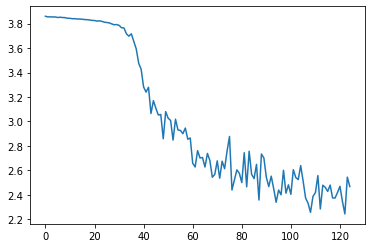

In [ ]:
# slow

# standard lm

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


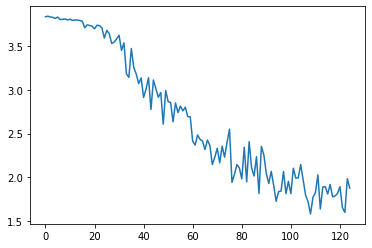

In [ ]:
# slow, rdkit

# fp conditional lm

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

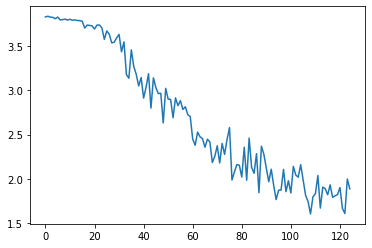

In [ ]:
# slow

# text conditional lm

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()


d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

encoder = LSTM_Encoder(
                        d_vocab,
                        d_embedding,
                        d_hidden,
                        n_layers,
                        d_latent,
                        input_dropout=input_dropout,
                        lstm_dropout=lstm_dropout
                    )

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

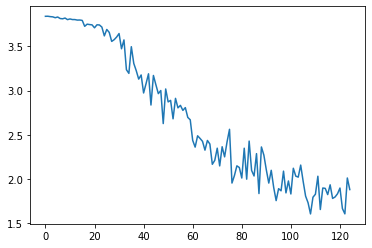

In [ ]:
# slow

# vec to text

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()

encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

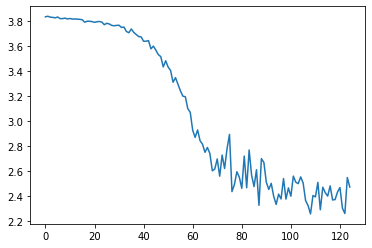

In [ ]:
# slow

# vec to text with rollout

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()

encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True
forward_rollout = True
p_force = 1.
force_decay = .9

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx,
                               forward_rollout=forward_rollout,
                               p_force=p_force,
                               force_decay=force_decay)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

In [ ]:
# hide
from nbdev.export import notebook2script; notebook2script()